In [6]:
import numpy as np
# import seaborn as sns
import pandas as pd
import os.path

import matplotlib.pyplot as plt

import tifffile 
import czifile

from skimage import transform
from scipy import ndimage

import random 
import math

In [7]:
from skimage.registration import optical_flow_tvl1


In [8]:
movie_dir =  '/mnt/d/lding/actomyosin/data/data_Rachel/Movies/LifeAct and NMY2-GFP'
movie_name = 'LifeAct-NMY2-GFP'
patch_size = 32


####################
root_processed_data_dir = '/mnt/d/lding/actomyosin/data/processed_data'
root_partitioned_data_dir = '/mnt/d/lding/actomyosin/data/partitioned_data_rand_flow'
root_plot_dir = '/mnt/d/lding/actomyosin/analysis_results'

processed_data_dir =  os.path.join(root_processed_data_dir, movie_name)

partitioned_data_dir =  os.path.join(root_partitioned_data_dir, movie_name+'_patchsize_'+str(patch_size))
plot_dir =  os.path.join(root_plot_dir, movie_name+'_patchsize_'+str(patch_size))

if not os.path.isdir(processed_data_dir):
    os.makedirs(processed_data_dir)
if not os.path.isdir(partitioned_data_dir):
    os.makedirs(partitioned_data_dir)
if not os.path.isdir(plot_dir):
    os.makedirs(plot_dir)



In [9]:
def rotate_coor(x_i,y_i,x_c,y_c,rotate_angle):
 
    rotate_angle = rotate_angle*np.pi/180
 
    x_o = (x_i-x_c)*math.cos(rotate_angle) - (2*y_c-y_i-y_c)*math.sin(rotate_angle) +x_c
    y_o = -(x_i-x_c)*math.sin(rotate_angle) - (2*y_c-y_i-y_c)*math.cos(rotate_angle) +(2*y_c-y_c)

    return([x_o,y_o])

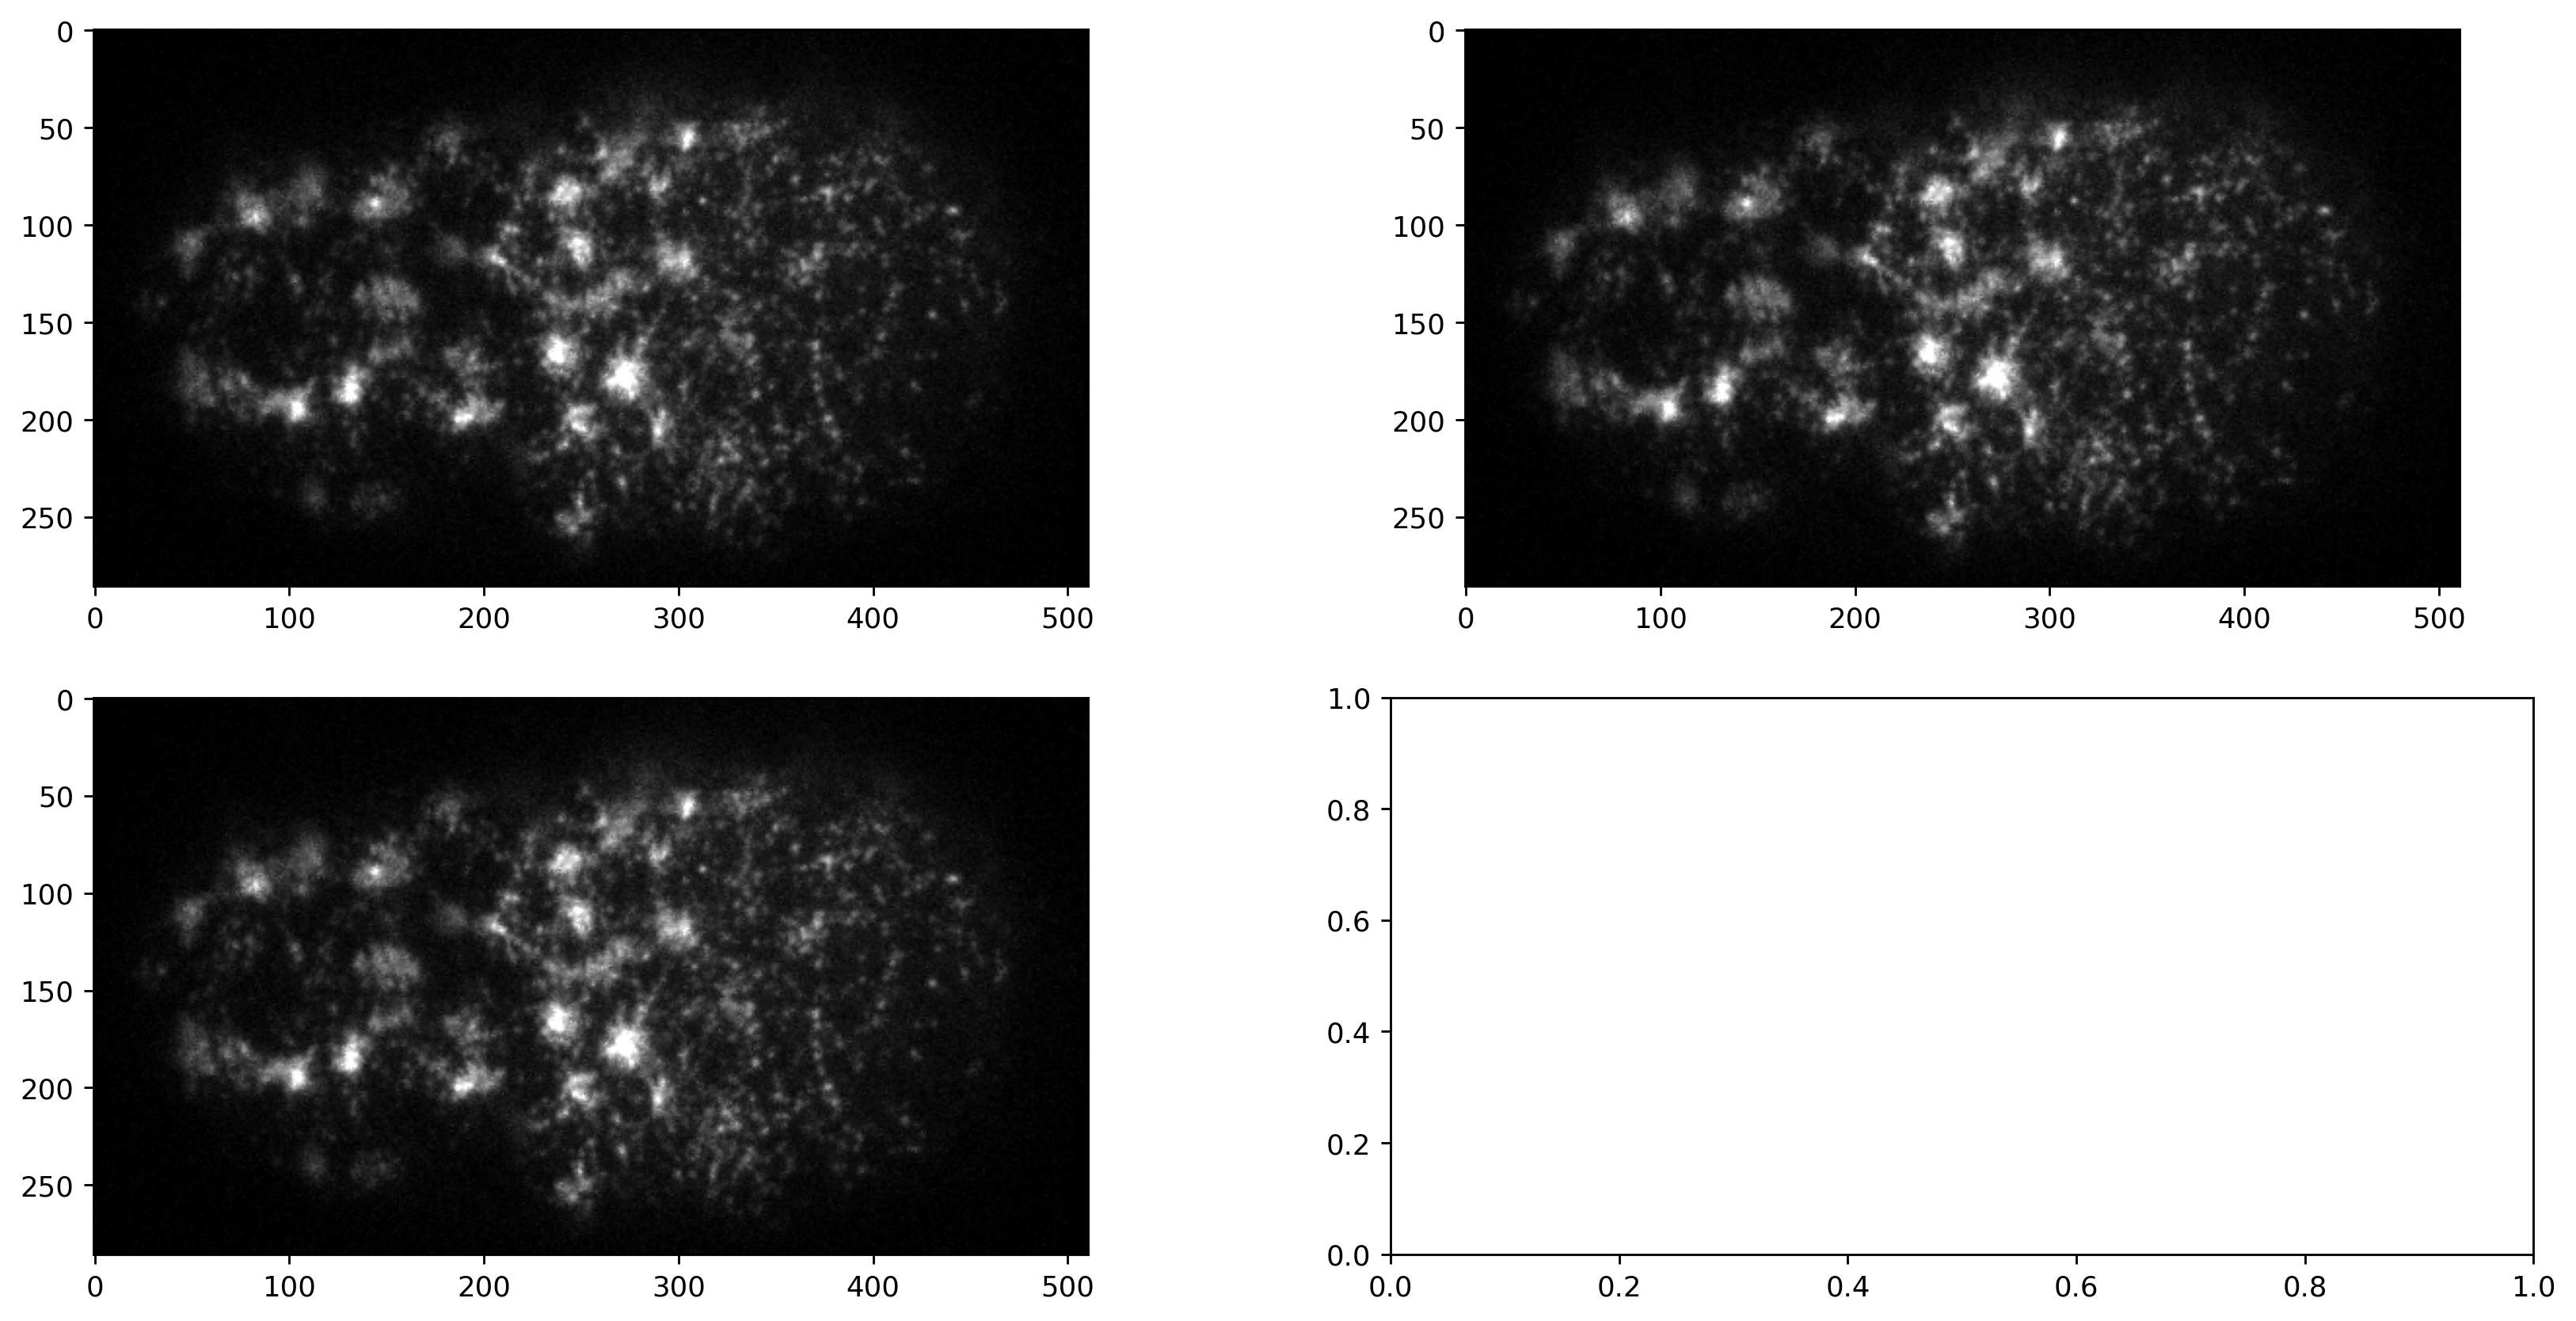

In [10]:
filenames = [x for x in os.listdir(movie_dir) if os.path.isfile(os.path.join(movie_dir, x)) and ('.tif' in x)]


# for filenameID in range(1,len(filenames)):
for filenameID in range(1,2):

    filename = filenames[filenameID]

    movie_processed_data_dir =  os.path.join(processed_data_dir, filename[:-4])
    movie_partitioned_data_dir =  os.path.join(partitioned_data_dir, filename[:-4])
    movie_plot_dir =  os.path.join(plot_dir, filename[:-4])

    if not os.path.isdir(movie_processed_data_dir):
        os.makedirs(movie_processed_data_dir)
    if not os.path.isdir(movie_partitioned_data_dir):
        os.makedirs(movie_partitioned_data_dir)
    if not os.path.isdir(movie_plot_dir):
        os.makedirs(movie_plot_dir)


    img = tifffile.imread(os.path.join(movie_dir,filename))

    smooth_img = ndimage.gaussian_filter(img,sigma=1,mode='nearest',truncate=3)        

    all_values = smooth_img.reshape([img.shape[0]*img.shape[1]*img.shape[2],1])
    mean_threshold = np.mean(all_values)-(0.45)*np.std(all_values)

    num_of_frames = img.shape[0]
    # num_of_frames = 500

    # 
    # for frame_ID in range(0,num_of_frames-1):  
    for frame_ID in range(0,1):
        data_prep_record = pd.DataFrame(columns=['movie_dir','filename','frame_ID','x_c','y_c','rand_angle','rand_tx','rand_ty',
                                                    'x_corner1','x_corner2','x_corner3','x_corner4','y_corner1','y_corner2','y_corner3','y_corner4',
                                                    'movie_partitioned_data_dir','crop_img_filename','movie_plot_dir','plot_filename'])


        train_t0_img = img[frame_ID,:,:].squeeze().astype(np.float)/255
        train_t1_img = img[frame_ID,:,:].squeeze().astype(np.float)/255


        v, u = optical_flow_tvl1(train_t0_img, train_t0_img)
        nr, nc = train_t0_img.shape
        row_coords, col_coords = np.meshgrid(np.arange(nr), np.arange(nc), indexing='ij')


        fig, ax = plt.subplots(2,2, figsize=(16,8), dpi=256, facecolor='w', edgecolor='k')
        ax[0,0].imshow(train_t0_img, cmap=plt.cm.gray,vmax=1,vmin=0)
        ax[0,1].imshow(train_t1_img, cmap=plt.cm.gray,vmax=1,vmin=0)
        ax[1,0].imshow(train_t0_img, cmap=plt.cm.gray,vmax=1,vmin=0)

        # ax[1,0].quiver(row_coords,col_coords,v,u)
        
                


        
        train_seg = (smooth_img[frame_ID,:,:].squeeze())>mean_threshold
        train_seg = (ndimage.binary_fill_holes(train_seg)).astype(np.float64)

        
        fig_accu, ax_accu = plt.subplots(1,2, figsize=(16,8), dpi=256, facecolor='w', edgecolor='k')
        ax_accu[0].imshow(train_t0_img, cmap=plt.cm.gray,vmax=1,vmin=0)
        ax_accu[1].imshow(train_seg, cmap=plt.cm.gray,vmax=1,vmin=0)
        
        # tifffile.imsave(os.path.join(movie_processed_data_dir,'t'+str(frame_ID).zfill(4)+'.tif'), train_img)
        # plt.rcParams["figure.figsize"] = (10,5)
        # plt.imshow(train_img*1.2*(train_seg), cmap=plt.cm.gray)
        # plt.axis('off')

        x_num = int(np.floor(img.shape[2]/patch_size))
        y_num = int(np.floor(img.shape[1]/patch_size))
        
        x_0 = int((img.shape[2] - x_num*patch_size)/2)
        y_0 = int((img.shape[1] - y_num*patch_size)/2)
        

        # for x_i in range(2):
        #     for y_i in range(2):
                
        for x_i in range(x_num):
            for y_i in range(y_num):

                y_c = int(y_0+(y_i-0.5)*patch_size)
                x_c = int(x_0+(x_i-0.5)*patch_size)

                y_left = y_c - patch_size
                x_left = x_c - patch_size

                y_right = y_c + patch_size
                x_right = x_c + patch_size


                if y_left < 0 or x_left < 0 or y_right >= img.shape[1] or x_right >= img.shape[2]:
                    continue

                patch_img = train_t0_img[y_left:y_right,x_left:x_right]
                
                patch_seg = train_seg[y_left:y_right,x_left:x_right]
                rand_angle = random.random() * 0
                rand_tx = int(random.random() * 16 - 8)
                rand_ty = int(random.random() * 16 - 8)
                

                rotated_patch_img = transform.rotate(patch_img, rand_angle, resize=False, center=None, order=None, mode='constant', cval=0, clip=True)
                rotated_patch_seg = transform.rotate(patch_seg, rand_angle, resize=False, center=None, order=None, mode='constant', cval=0, clip=True)
                                
                cx_left = 16-rand_tx
                cx_right = 32+16-rand_tx
                cy_up = 16-rand_ty
                cy_down = 32+16-rand_ty

                crop_patch_img = rotated_patch_img[16-rand_ty:32+16-rand_ty,16-rand_tx:32+16-rand_tx]
                crop_patch_seg = rotated_patch_seg[16-rand_ty:32+16-rand_ty,16-rand_tx:32+16-rand_tx]

                if((crop_patch_seg.mean())<0.95):
                    continue

                crop_img_filename = 't'+str(frame_ID).zfill(4)+'x'+str(x_c).zfill(4)+'y'+str(y_c).zfill(4)+'ps'+str(patch_size)+'.tif'
                tifffile.imsave(os.path.join(movie_partitioned_data_dir,crop_img_filename), crop_patch_img)


                X_TransRotCrop = np.array([cx_left, cx_left, cx_right, cx_right, cx_left])
                Y_TransRotCrop = np.array([cy_up, cy_down, cy_down, cy_up, cy_up])

                [X_bigger_patch, Y_bigger_patch] = rotate_coor(X_TransRotCrop,Y_TransRotCrop,32,32,-rand_angle)


                fig, ax = plt.subplots(2,4, figsize=(16,8), dpi=256, facecolor='w', edgecolor='k')
                ax[0,0].imshow(train_img, cmap=plt.cm.gray,vmax=1,vmin=0)
                ax[0,0].plot([x_left, x_left, x_right, x_right, x_left],[y_left,y_right, y_right, y_left,y_left],color='r')
                ax[0,0].plot(X_bigger_patch+x_left, Y_bigger_patch+y_left,color='green')

                ax[0,1].imshow(train_seg, cmap=plt.cm.gray,vmax=1,vmin=0)
                ax[0,1].plot([x_left, x_left, x_right, x_right, x_left],[y_left,y_right, y_right, y_left,y_left],color='r')
                ax[0,0].plot(X_bigger_patch+x_left, Y_bigger_patch+y_left,color='green')

                

                ax[0,2].imshow(patch_img, cmap=plt.cm.gray,vmax=1,vmin=0)
                ax[0,2].plot(X_bigger_patch, Y_bigger_patch,color='green')

                ax[0,3].imshow(patch_seg, cmap=plt.cm.gray,vmax=1,vmin=0)
                ax[0,3].plot(X_bigger_patch, Y_bigger_patch,color='green')

                ax[1,0].imshow(rotated_patch_img, cmap=plt.cm.gray,vmax=1,vmin=0)
                ax[1,0].plot([16-rand_tx, 16-rand_tx, 32+16-rand_tx, 32+16-rand_tx, 16-rand_tx],[16-rand_ty,32+16-rand_ty, 32+16-rand_ty, 16-rand_ty,16-rand_ty],color='r')

                ax[1,1].imshow(rotated_patch_seg, cmap=plt.cm.gray,vmax=1,vmin=0)
                ax[1,1].plot([16-rand_tx, 16-rand_tx, 32+16-rand_tx, 32+16-rand_tx, 16-rand_tx],[16-rand_ty,32+16-rand_ty, 32+16-rand_ty, 16-rand_ty,16-rand_ty],color='r')

                ax[1,2].imshow(crop_patch_img, cmap=plt.cm.gray,vmax=1,vmin=0)
                ax[1,3].imshow(crop_patch_seg, cmap=plt.cm.gray,vmax=1,vmin=0)
                
                plot_filename = 'plot_grid_t'+str(frame_ID).zfill(4)+'_xc'+str(x_c)+'_yc'+str(y_c)+ '.png'
                fig.savefig(os.path.join(movie_plot_dir,plot_filename),bbox_inch='tight')
                plt.close(fig) 
                
                ax_accu[0].plot(X_bigger_patch+x_left, Y_bigger_patch+y_left,color='green')
                ax_accu[1].plot(X_bigger_patch+x_left, Y_bigger_patch+y_left,color='green')


                
                s = pd.Series([movie_dir, filename, frame_ID, x_c,y_c,rand_angle,rand_tx,rand_ty,
                    X_bigger_patch[0]+x_left,X_bigger_patch[1]+x_left,X_bigger_patch[2]+x_left,X_bigger_patch[3]+x_left,
                    Y_bigger_patch[0]+y_left,Y_bigger_patch[1]+y_left,Y_bigger_patch[2]+y_left,Y_bigger_patch[3]+y_left,
                    movie_partitioned_data_dir,crop_img_filename,movie_plot_dir,plot_filename],
                    index=['movie_dir','filename','frame_ID','x_c','y_c','rand_angle','rand_tx','rand_ty',
                                            'x_corner1','x_corner2','x_corner3','x_corner4','y_corner1','y_corner2','y_corner3','y_corner4',
                                            'movie_partitioned_data_dir','crop_img_filename','movie_plot_dir','plot_filename'])
                
                data_prep_record = data_prep_record.append(s,ignore_index=True)

        data_prep_record.to_csv(os.path.join(movie_plot_dir,'data_prep_record_'+str(filenameID)+'_t'+str(frame_ID)+'.csv'))

        fig_accu.savefig(os.path.join(movie_plot_dir,'grid_t'+str(frame_ID).zfill(4)+'.png'),bbox_inch='tight')   
        plt.close(fig_accu)   
                